<a href="https://colab.research.google.com/github/yuti-patel/Monte-Carlo-Simulations/blob/main/MonteCarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
from scipy.stats import norm, t
import matplotlib.pyplot as plt
import seaborn as sns
from multiprocessing import Pool

In [4]:
#Gets current price of a particular stock ticker
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

#Need to add how to deal with stocks that weren't listed before start of lookback_period

#Gets the data for a list of stocks from start to end date. Returns percent change and covariance Matrix
def getData(stocks, start, end):
    stockData = yf.download(stocks, start, end)['Close']
    returns = stockData.pct_change().dropna()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns, meanReturns, covMatrix

#Calculates weight of stocks in a portfolio given no. of each stock
def calcWeights(stocks, stock_nos):
  stock_val = np.zeros(shape = (len(stocks)), dtype = np.float32)
  for ind, stock in enumerate(stocks):
    stock_val[ind]=(get_current_price(stock)*stock_nos[ind])
  total_val = np.sum(stock_val)
  return [stock/total_val for stock in stock_val], total_val

#Runs the actual Monte Carlo Simulation
def MonteCarlo(weights, meanReturns, total_val, covMatrix, T = 100, mc_sims = 400):
  meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns) #Nothing but the avg returns for each stock
  meanM = meanM.T
  portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0) #Here, we will add portfolio results for m simulations over T time periods
  portfolio_return_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
  #For loop running the actual sims
  for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights))) #Each stock is assumed a normal variable to daily returns are a random walk through normal distribution
    L = np.linalg.cholesky(covMatrix) #We use a Cholesky Decomposition to Generate our Multivariate Normal Distribution. 
    dailyReturns = meanM + np.inner(L, Z) 
    '''
    Daily returns are nothing but the Mean +- the Inner product of Separate Normal Distributions and the Cholesky Lower Triangle Matrix(L)
    Here, this inner product is what generates our Multivariate Normal Distribution.
    For the purposes of this Monte Carlo SIm, we assume portfolio returns to be a Multivariate Normal Distribution and each simulation is a random walk through the same.
    For more details, refer http://www.math.kent.edu/~reichel/courses/monte.carlo/alt4.7c.pdf
      '''
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*total_val #Multiplying by weights and initial portfolio value to get our returns
    portfolio_return_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*100

  return portfolio_sims, portfolio_return_sims

def VaR(returns, alpha=5):
  return np.percentile(returns, alpha)
    
def cVaR(returns, alpha=5):
  belowVaR = returns <= VaR(returns, alpha=alpha)
  return returns[belowVaR].mean()

In [12]:


percent = True #Displays output in percent terms instead of absolute
compare_market = False #Doesn't account for market conditions. Can be set to True

#First taking user input
no_stocks = int(input('Please enter the number of stocks: '))

stockList = []
stock_nos = []
for i in range(no_stocks):
  stock = input('Please Enter NSE Ticker of Stock {:d}: '.format(i+1))
  stockList.append(stock)
  no = int(input('Please Enter No. of shares of {:s} you own: '.format(stock)))
  stock_nos.append(no)
lookback_period = float(input('Please enter the lookback period you wish to use data from (yrs, can be a decimal): '))
mc_sims = int(input('Please enter the number of simulations you wish to run(try to keep under 100,000): '))
T = float(input('Please enter the number of yrs into the future you want to predict portfolio returns (yrs, can be decimal): '))

#Making a few rudimentary changes to the input for processing like converting days to years
stocks = [st + '.NS' for st in stockList]
lookback_period = int(lookback_period*365)
T = int(T*365)
if len(stockList)<=1 or compare_market: #If only 1 stock or compare_market is True, compare our stock to 0 shares of NIFTY as market 
  stocks.append('^NSEI') 
  stock_nos.append(0)
percent = True #Displays output in percent terms instead of absolute

Please enter the number of stocks: 15
Please Enter NSE Ticker of Stock 1: HINDUNILVR
Please Enter No. of shares of HINDUNILVR you own: 4
Please Enter NSE Ticker of Stock 2: RELAXO
Please Enter No. of shares of RELAXO you own: 6
Please Enter NSE Ticker of Stock 3: VOLTAS
Please Enter No. of shares of VOLTAS you own: 3
Please Enter NSE Ticker of Stock 4: POONAWALLA
Please Enter No. of shares of POONAWALLA you own: 6
Please Enter NSE Ticker of Stock 5: FINEORG
Please Enter No. of shares of FINEORG you own: 5
Please Enter NSE Ticker of Stock 6: ENDURANCE
Please Enter No. of shares of ENDURANCE you own: 4
Please Enter NSE Ticker of Stock 7: NOCIL
Please Enter No. of shares of NOCIL you own: 4
Please Enter NSE Ticker of Stock 8: ASIANPAINT
Please Enter No. of shares of ASIANPAINT you own: 3
Please Enter NSE Ticker of Stock 9: ICICIBANK
Please Enter No. of shares of ICICIBANK you own: 3
Please Enter NSE Ticker of Stock 10: TATACONSUM
Please Enter No. of shares of TATACONSUM you own: 6
Please 

In [13]:
#For debugging

# stockList = ['NAVINFLUOR', 'ZOMATO']
# stock_nos = [1, 2]
# stocks = [st + '.NS' for st in stockList]
# if len(stockList)==1: #If only 1 stock, compares to NIFTY
#   stocks.append('^NSEI') 
#   stock_nos.append(0)
# lookback_period = 100 #Let's use historical data from 300 days
# mc_sims = 10000 # number of simulations
# T = 365 #Let's predict Portfolio Value 1 year from now
# percent = True #Decides whether to print Portfolio Value or Percent Change

In [14]:
end = dt.date.today() #Sets today's date as end date
start = end - dt.timedelta(days = lookback_period)
returns, meanReturns, covMatrix = getData(stocks, start, end)
weights, total_val = calcWeights(stocks, stock_nos)
portfolio_vals, portfolio_percents = MonteCarlo(weights, meanReturns, total_val, covMatrix, T, mc_sims)
if(percent):
  results = portfolio_percents[-1, :]
else:
  results = portfolio_vals[-1, :]

[*********************100%***********************]  15 of 15 completed


Initial Portfolio Value: Rs. 92911


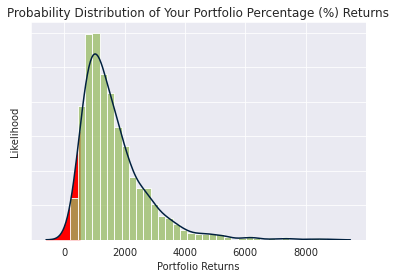

25th Percentile Returns: 905.88 %
Average (50th Percentile) Returns: 1349.33 %
75th Percentile Returns: 2045.82 %
Variance at Risk: 529.02 %
Conditional Variance at Risk: 407.73 %


In [15]:
#SNS Plot for our simulated returns
sns.set_style('darkgrid')
ax = sns.histplot(data=results, kde=False, stat='density', bins = 35, fill=True, color = '#97BC62FF')
sns.kdeplot(data=results, color='#00203FFF', ax=ax)
kde_x, kde_y = ax.lines[0].get_data()
x0 = VaR(results)
ax.fill_between(kde_x, kde_y, where=(kde_x<x0) , interpolate=True, color = 'red')
if(not percent):
  ax.set_title("Probability Distribution of Your Portfolio Returns")
else:
  ax.set_title("Probability Distribution of Your Portfolio Percentage (%) Returns")
ax.set(xlabel='Portfolio Returns', ylabel='Likelihood')
ax.set_yticklabels([])
print("Initial Portfolio Value: Rs. {:d}".format(int(total_val)))
plt.show()
if(not percent):
  print("25th Percentile Returns: {:.2f}".format(np.percentile(results, 25)))
  print("Average (50th Percentile) Returns: {:.2f}".format(np.percentile(results, 50)))
  print("75th Percentile Returns: {:.2f}".format(np.percentile(results, 75)))
  print("Variance at Risk: {:.2f}".format(VaR(results)))
  print("Conditional Variance at Risk: {:.2f}".format(cVaR(results)))
else:
  print("25th Percentile Returns: {:.2f} %".format(np.percentile(results, 25)))
  print("Average (50th Percentile) Returns: {:.2f} %".format(np.percentile(results, 50)))
  print("75th Percentile Returns: {:.2f} %".format(np.percentile(results, 75)))
  print("Variance at Risk: {:.2f} %".format(VaR(results)))
  print("Conditional Variance at Risk: {:.2f} %".format(cVaR(results)))

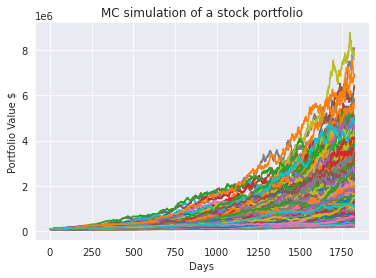

In [16]:
plt.plot(portfolio_vals)
plt.ylabel('Portfolio Value $')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()